In [23]:
import nltk
import spacy
import seaborn as sns  
from rake_nltk import Rake
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import fitz  # PyMuPDF til at læse PDF-filer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from langdetect import detect
import ipywidgets as widgets
from IPython.display import display
import networkx as nx
import numpy as np
from nrclex import NRCLex
from scipy.stats import linregress
import pandas as pd
from collections import Counter
from itertools import combinations
from nltk.corpus import stopwords

# NLTK data downloads
nltk.download('punkt')
nltk.download('stopwords')

# Indlæs dansk og engelsk spaCy-modeller
nlp_da = spacy.load("da_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# NLTK Stopord
danish_stopwords = stopwords.words('danish')
english_stopwords = stopwords.words('english')

# Globale variable til at gemme tekst
cleaned_text_global = None
themes_global = None

# ---- Sprogdetektion og modelvalg ---- #

# Funktion til sprogdetektering
def detect_language(text):
    try:
        language = detect(text)
        if language == "da":
            print("Sproget er dansk.")
            return "da"
        elif language == "en":
            print("Sproget er engelsk.")
            return "en"
        else:
            print(f"Sprog '{language}' understøttes ikke direkte. Antager engelsk som fallback.")
            return "en"
    except Exception as e:
        print(f"Fejl ved sprogdetektion: {e}. Antager engelsk som fallback.")
        return "en"

# Funktion til at hente den korrekte spaCy-model baseret på sproget
def get_nlp_model(language):
    if language == "en":
        return spacy.load("en_core_web_sm")
    elif language == "da":
        return spacy.load("da_core_news_sm")
    else:
        raise ValueError(f"Unsupported language: {language}")


[nltk_data] Downloading package punkt to /Users/aw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# hjælpefunktioner
# Funktioner til at læse, rense, analysere og visualisere
def read_pdf(file_path):
    text = ""
    with fitz.open(file_path) as pdf:
        for page_num in range(pdf.page_count):
            page = pdf[page_num]
            text += page.get_text()
    return text

# Funktion til at læse PDF-filer
def read_pdf(file_path):
    text = ""
    with fitz.open(file_path) as pdf:
        for page_num in range(pdf.page_count):
            page = pdf[page_num]
            text += page.get_text()
    return text

# Udvidet clean_text funktion for at fjerne støj
def clean_text(text):
    # Fjern URL'er og metadata-ord
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\b(Terms|Conditions|Journal|homepage|ISSN|access|use)\b', '', text, flags=re.IGNORECASE)

    # Fjern linjeskift og specielle tegn, som kan skabe støj
    text = re.sub(r'[^a-zA-ZÆØÅæøå .!?]', '', text)  # Kun bogstaver og punktuation
    text = re.sub(r'\s+', ' ', text)  # Fjern overskydende mellemrum
    return text


# Funktion til at opsummere tekst med TextRank
def summarize_text(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("danish"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join(str(sentence) for sentence in summary)


# Funktion til at detektere sprog
def detect_language(text):
    return detect(text)


# Funktion til at visualisere temaerne
def plot_themes(common_words):
    words, frequencies = zip(*common_words)
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.bar(words, frequencies, color=plt.cm.viridis(range(len(words))))

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel("Ord", fontsize=14)
    ax.set_ylabel("Frekvens", fontsize=14)
    ax.set_title("De mest almindelige ord i teksten", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Funktion til at identificere de mest almindelige ord (temaer)
def identify_themes(text):
    language = detect_language(text)
    if language == "da":
        nlp = nlp_da
        stop_words = nlp.Defaults.stop_words | set(string.punctuation)
    elif language == "en":
        nlp = nlp_en
        stop_words = nlp.Defaults.stop_words | set(string.punctuation) | {"the", "a", "of", "and", "in", "to", "is", "as", "it", "on"}
    else:
        print(f"Sprog '{language}' understøttes ikke.")
        return []

    # Tokenizer og filtrerer stopord
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    freq_dist = FreqDist(filtered_tokens)
    common_words = freq_dist.most_common(10)
    return common_words

In [25]:
import json
from docx import Document

# Funktion til at læse txt-filer
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

# Funktion til at læse CSV-filer
def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df

# Funktion til at læse DOCX-filer
def read_docx(file_path):
    doc = Document(file_path)
    content = "\n".join([para.text for para in doc.paragraphs])
    return content

# Funktion til at læse Excel-filer
def read_excel(file_path):
    df = pd.read_excel(file_path, engine='openpyxl')
    return df

# Funktion til at læse JSON-filer
def read_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

In [26]:
def upload_file(change):
    global cleaned_text_global
    if change['new']:
        uploaded_file = change['new'][0]  # Access the first file in the upload
        file_content = uploaded_file['content']
        file_name = uploaded_file['name']
        
        # Gem den uploadede fil midlertidigt
        file_path = file_name
        with open(file_path, 'wb') as f:
            f.write(file_content)
        
        # Læs og rens teksten afhængig af filtypen
        if file_path.endswith('.pdf'):
            text = read_pdf(file_path)
        elif file_path.endswith('.txt'):
            text = read_txt(file_path)
        elif file_path.endswith('.csv'):
            df = read_csv(file_path)
            text = df.to_string()  # Konverter data til string for at behandle det som tekst
        elif file_path.endswith('.docx'):
            text = read_docx(file_path)
        elif file_path.endswith('.xlsx'):
            df = read_excel(file_path)
            text = df.to_string()
        elif file_path.endswith('.json'):
            data = read_json(file_path)
            text = json.dumps(data, indent=2)  # Konverter JSON-data til læsbar string
        else:
            print("Filtypen understøttes ikke.")
            return
        
        # Rens og gem den importerede tekst
        cleaned_text = clean_text(text)
        if len(cleaned_text.strip()) == 0:
            print("Renset tekst er tom. Tjek filen.")
        else:
            cleaned_text_global = cleaned_text
            print("Tekst er uploadet og renset.")
    else:
        print("Ingen fil er uploadet.")

# Opret en upload-widget
upload_widget = widgets.FileUpload(accept='.pdf,.txt,.csv,.docx,.xlsx,.json', multiple=False)
upload_widget.observe(upload_file, names='value')
display(upload_widget)


FileUpload(value=(), accept='.pdf,.txt,.csv,.docx,.xlsx,.json', description='Upload')

Tekst er uploadet og renset.


In [27]:
# Funktion til beregning af LIX (Læsbarhedsindeks) for dansk
def calculate_lix(text):
    sentences = nltk.sent_tokenize(text, language="danish")
    words = nltk.word_tokenize(text, language="danish")
    long_words = [word for word in words if len(word) > 6]

    num_sentences = len(sentences)
    num_words = len(words)
    num_long_words = len(long_words)

    if num_sentences == 0:
        return None  # For at undgå division med nul

    lix = num_words / num_sentences + (num_long_words * 100) / num_words
    return lix

# Funktion til at bestemme sprogniveau baseret på LIX
def lix_level(lix):
    if lix < 25:
        return "Meget let (Børnelitteratur)"
    elif lix < 35:
        return "Let (Ungdomslitteratur)"
    elif lix < 45:
        return "Middel (Almindelig litteratur)"
    elif lix < 55:
        return "Svær (Faglitteratur)"
    else:
        return "Meget svær (Videnskabelige tekster)"

# Funktion til manuel beregning af Flesch-Kincaid for engelsk
def calculate_flesch_kincaid(text):
    sentences = nltk.sent_tokenize(text)
    words = nltk.word_tokenize(text)
    syllables = sum(len(re.findall(r'[aeiouyAEIOUY]+', word)) for word in words)

    num_sentences = len(sentences)
    num_words = len(words)

    if num_sentences == 0 or num_words == 0:
        return None, None  # Undgå division med nul

    # Flesch Reading Ease
    flesch_score = 206.835 - 1.015 * (num_words / num_sentences) - 84.6 * (syllables / num_words)

    # Flesch-Kincaid Grade Level
    grade_level = 0.39 * (num_words / num_sentences) + 11.8 * (syllables / num_words) - 15.59

    return flesch_score, grade_level

# Funktion til beregning af læsbarhed afhængigt af sprog
def readability_analysis(text):
    language = detect(text)

    if language == "da":
        lix = calculate_lix(text)
        if lix is not None:
            level = lix_level(lix)
            print(f"LIX (Dansk Læsbarhedsindeks): {lix:.2f}")
            print(f"LIX Niveau: {level}")
        else:
            print("LIX kunne ikke beregnes på grund af manglende sætninger.")
    elif language == "en":
        # Brug manuel beregning for Flesch-Kincaid
        flesch_score, grade_level = calculate_flesch_kincaid(text)
        if flesch_score is not None:
            print(f"Flesch Reading Ease (Engelsk): {flesch_score:.2f}")
            print(f"Flesch-Kincaid Grade Level: {grade_level:.2f}")
        else:
            print("Flesch-Kincaid kunne ikke beregnes på grund af manglende sætninger eller ord.")
    else:
        print("Sproget understøttes ikke af læsbarhedsberegningen.")

# Eksempel på brug
if cleaned_text_global:
    readability_analysis(cleaned_text_global)
else:
    print("cleaned_text_global er tom eller ikke defineret.")

LIX (Dansk Læsbarhedsindeks): 48.97
LIX Niveau: Svær (Faglitteratur)


In [28]:
def display_summary():
    if cleaned_text_global:
        print("\nOpsummering af teksten:\n", summarize_text(cleaned_text_global))

    else:
        print("cleaned_text_global er tom eller ikke defineret.")

# Kør opsummeringsvisningen
display_summary()



Opsummering af teksten:
 Afsluttende anbefalinger Litteratur Bilag Tabeller Bilag Udfordringer i forhold til at integrere kreativ tænkning i uddannelse ifølge PISA Hovedresultater OECD har i PISA udviklet en test af elevers kreative evne Kreativ tænkning i PISA er defineret som kompetencen til at engagere sig produktivt i generering evaluering og forbedring af ider der kan resultere i originale og effektive løsninger fremskridt i viden og virkningsfulde udtryk for fantasi og forestillingsevne. En sammenligning af landes testresultat i kreativ tænkning Gennemsnitlig score i Kreativ tænkning At få og forme forskellige ider opgaver At få og forme nye og nyttige ider opgaver At evaluere og forbedre ider opgaver At få og forme ider til skriftligt udtryk opgaver At få og forme ider til visuelt udtryk opgaver At få og forme ider til løsning af samfundsproblemer opgaver At få og forme ider til løsning af videnskabelige problemer opgaver Singapore Korea Canada Australien New Zealand Estland Fi

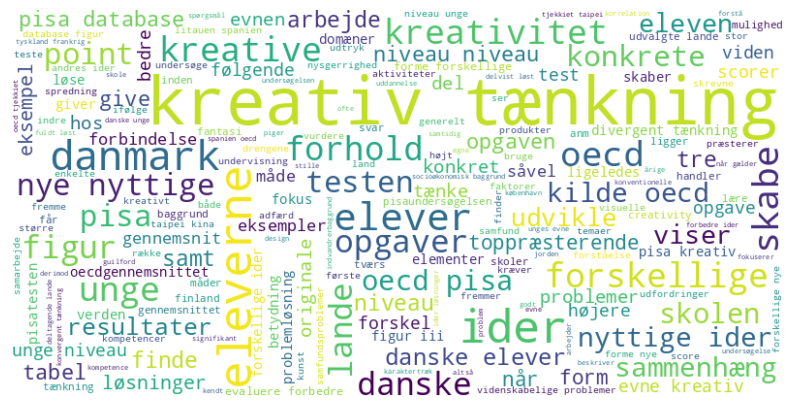

In [29]:
# Funktion til at generere ordsky
def generate_wordcloud(text):
    stop_words = nlp_da.Defaults.stop_words | set(string.punctuation)
    doc = nlp_da(text.lower())
    filtered_tokens = [token.text for token in doc if token.text not in stop_words and token.is_alpha and len(token) > 2]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Kald funktionen ved at sikre, at cleaned_text_global er defineret og ikke tom
if cleaned_text_global:
    generate_wordcloud(cleaned_text_global)
else:
    print("cleaned_text_global er tom eller ikke defineret.")


Identificerede temaer (mest almindelige ord):
tænkning: 257
kreativ: 254
ider: 166
oecd: 117
niveau: 92
pisa: 90
forskellige: 89
unge: 86
danske: 79
figur: 79


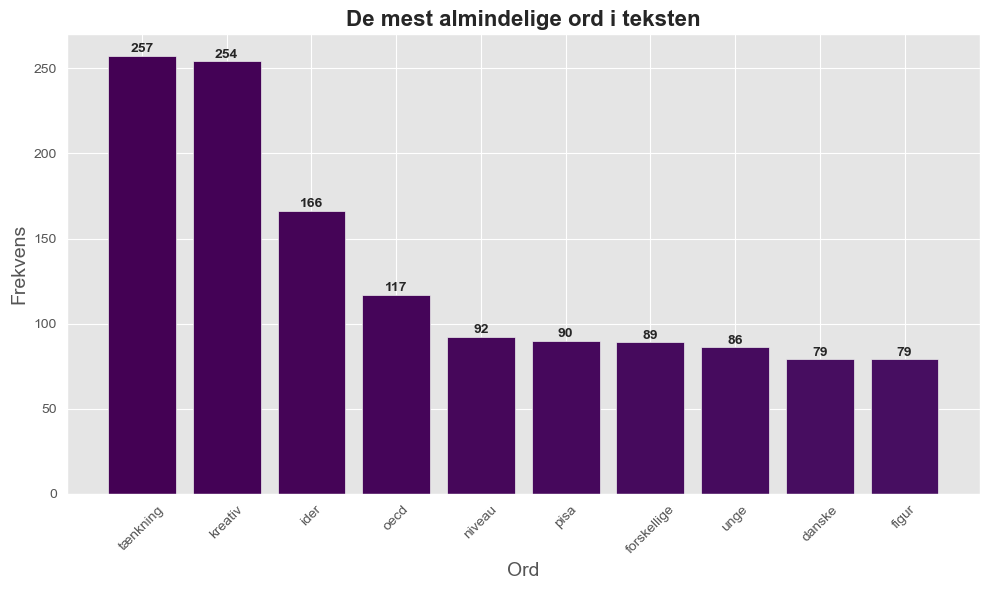

In [30]:
def identify_themes(text):
    # Kontroller om teksten er tom
    if not text:
        print("Teksten er tom.")
        return []

    # Bestem sproget og vælg den rigtige stopword-liste
    language = detect_language(text) if text else "da"  # Standardiser til dansk, hvis det fejler
    nlp, stop_words = (nlp_da, nlp_da.Defaults.stop_words | set(string.punctuation)) if language == "da" else (nlp_en, nlp_en.Defaults.stop_words | set(string.punctuation) | {"the", "a", "of", "and", "in", "to", "is", "as", "it", "on"})

    # Tilføj tilpassede stopord inkl. "samt"
    additional_stopwords = {"og", "at", "det", "som", "på", "er", "ubu", "pa", "breredygtighed", "breredygtig", "vrere", "samt"} if language == "da" else set()
    stop_words |= additional_stopwords

    # Tokenizer teksten og filtrer stopord
    try:
        doc = nlp(text.lower())
        filtered_tokens = [token.text for token in doc if token.text not in stop_words and token.is_alpha and len(token) > 2]
        return FreqDist(filtered_tokens).most_common(10)
    except Exception as e:
        print(f"Fejl under tokenisering eller frekvensberegning: {e}")
        return []

# Kald funktionen og udskriv resultaterne, hvis der er nogen
themes = identify_themes(cleaned_text_global)
if themes:
    print("\nIdentificerede temaer (mest almindelige ord):")
    for word, frequency in themes:
        print(f"{word}: {frequency}")
    plot_themes(themes)
else:
    print("Ingen temaer fundet.")



In [31]:
# Funktion til sentimentanalyse
def sentiment_analysis(text):
    if not text:
        print("Teksten er tom.")
        return None
    try:
        blob = TextBlob(text)
        sentiment = blob.sentiment
        return sentiment
    except Exception as e:
        print(f"Der opstod en fejl under sentimentanalysen: {e}")
        return None

# Kald sentimentanalyse og tjek for fejl
if cleaned_text_global:
    sentiment = sentiment_analysis(cleaned_text_global)
    if sentiment:
      print("\nSentimentanalyse:")
      print(f"Tekstens stemning (polarity) er {sentiment.polarity:.2f}. Dette angiver, hvor positiv eller negativ teksten er,")
      print("hvor værdier går fra -1 til 1. En værdi tæt på -1 betyder meget negativ stemning, mens en værdi tæt på 1 er meget positiv.")
      print()
      print(f"Tekstens subjektivitet er {sentiment.subjectivity:.2f}. Dette måler, hvor subjektiv eller objektiv teksten er,")
      print("hvor værdier går fra 0 til 1. En værdi tæt på 0 betyder, at teksten er meget objektiv, mens en værdi tæt på 1 indikerer høj subjektivitet.")


else:
    print("cleaned_text_global er tom eller ikke defineret.")



Sentimentanalyse:
Tekstens stemning (polarity) er 0.01. Dette angiver, hvor positiv eller negativ teksten er,
hvor værdier går fra -1 til 1. En værdi tæt på -1 betyder meget negativ stemning, mens en værdi tæt på 1 er meget positiv.

Tekstens subjektivitet er 0.40. Dette måler, hvor subjektiv eller objektiv teksten er,
hvor værdier går fra 0 til 1. En værdi tæt på 0 betyder, at teksten er meget objektiv, mens en værdi tæt på 1 indikerer høj subjektivitet.


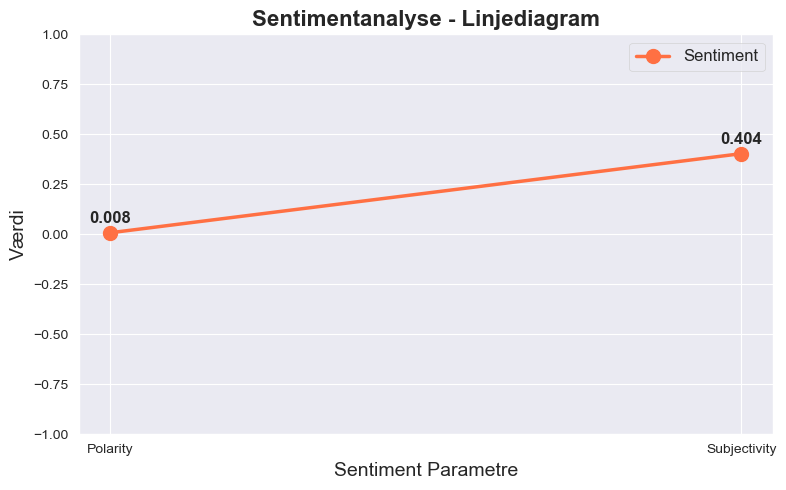

In [32]:
# Funktion til at visualisere sentimentanalyse som linjediagram
def plot_sentiment_line(sentiment):
    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity

    labels = ['Polarity', 'Subjectivity']
    values = [polarity, subjectivity]

    # Use seaborn style
    sns.set_style("darkgrid")  # Changed from plt.style.use to sns.set_style

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(labels, values, marker='o', color='#ff7043', markersize=10, linewidth=2.5, label="Sentiment")

    for i, value in enumerate(values):
        ax.text(i, value + 0.05, f"{value:.3f}", ha='center', fontsize=12, fontweight='bold')

    ax.set_ylim(-1, 1)
    ax.set_ylabel("Værdi", fontsize=14)
    ax.set_xlabel("Sentiment Parametre", fontsize=14)
    ax.set_title("Sentimentanalyse - Linjediagram", fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_sentiment_line(sentiment)

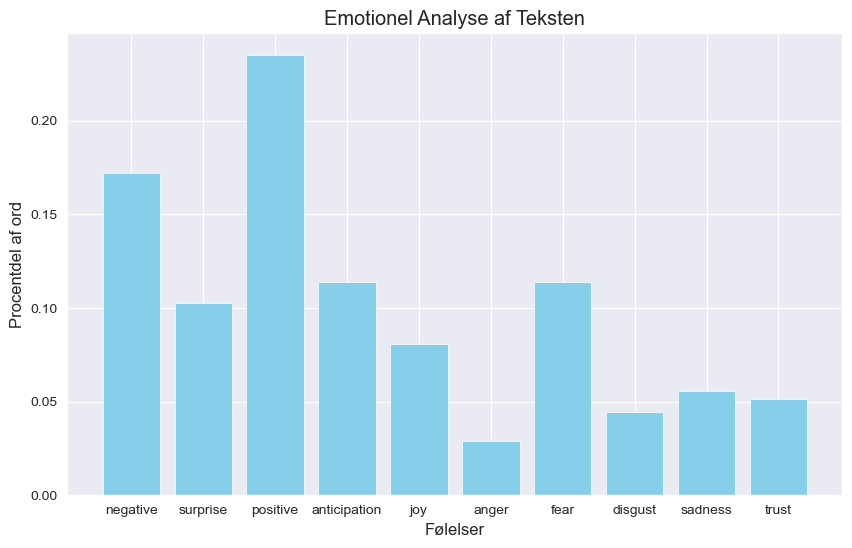

In [33]:
# Analyserer hele teksten: NRCLex laver en emotionel analyse af teksten, hvor hver kategori får tildelt en
# score baseret på antallet af ord, der matcher med den pågældende følelse.
# Funktion til udvidet emotionel analyse
def extended_emotion_analysis(text):
    # Lav NRCLex-analyse på hele teksten
    emotion = NRCLex(text)

    # Saml resultaterne i en ordbog
    emotion_counts = emotion.raw_emotion_scores  # Får en ordbog med følelseskategorier og antal
    total_words = sum(emotion_counts.values())

    # Konverter til procent
    emotion_percentages = {emotion: count / total_words for emotion, count in emotion_counts.items()}

    # Visualiser emotionerne som et søjlediagram
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_percentages.keys(), emotion_percentages.values(), color='skyblue')
    plt.xlabel("Følelser")
    plt.ylabel("Procentdel af ord")
    plt.title("Emotionel Analyse af Teksten")
    plt.show()

# Kør emotionel analyse på den globale rensede tekst
extended_emotion_analysis(cleaned_text_global)

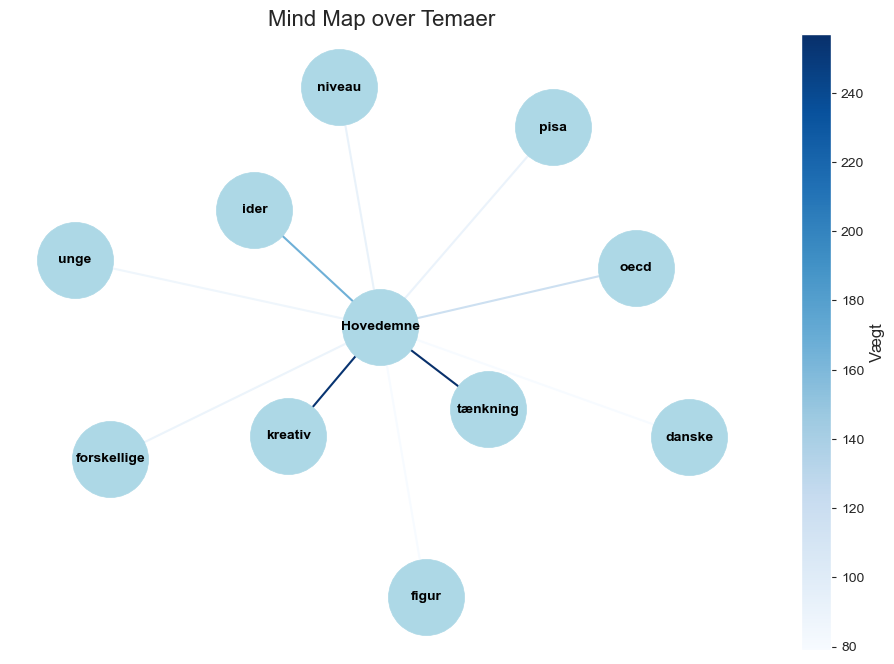

In [34]:
# Mind map-funktion
def create_mind_map(themes):
    G = nx.Graph()
    G.add_node("Hovedemne")
    for word, frequency in themes:
        G.add_node(word)
        G.add_edge("Hovedemne", word, weight=frequency)

    pos = nx.spring_layout(G, seed=42)
    fig, ax = plt.subplots(figsize=(12, 8)) # Create fig and ax
    edges = G.edges(data=True)
    edge_colors = [edge[2]['weight'] for edge in edges]

    # Pass the collection to the colorbar function
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm.set_array([]) # This is important to ensure the colorbar works correctly

    nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, ax=ax) # Draw on the ax
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000, ax=ax) # Draw on the ax
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax) # Draw on the ax
    plt.title("Mind Map over Temaer", fontsize=16)
    plt.axis('off')
    plt.colorbar(sm, ax=ax, label='Vægt') # Add colorbar to the ax
    plt.show()
create_mind_map(themes)

In [35]:
# Denne analyse skal tages med forbehold

def find_largest_sentiment_contrast(text):
    if not text or text.strip() == "":
        print("Teksten er tom og kan ikke analyseres.")
        return

    # Del teksten op i sætninger og filtrer ud kortere sætninger
    sentences = [s.strip() for s in text.split('.') if s.strip() and len(s.strip().split()) > 3]
    polarities = []

    # Beregn polarity for hver sætning
    for sentence in sentences:
        blob = TextBlob(sentence)
        polarities.append(blob.sentiment.polarity)

    # Find den største forskel mellem på hinanden følgende sætninger
    max_contrast = 0
    contrast_indices = (0, 1)
    for i in range(1, len(polarities)):
        contrast = abs(polarities[i] - polarities[i - 1])
        if contrast > max_contrast:
            max_contrast = contrast
            contrast_indices = (i - 1, i)

    # Udskriv de sætninger med den største kontrast
    if max_contrast > 0:
        print("De to sætninger med størst sentimentkontrast er:\n")
        print(f"Sætning 1: {sentences[contrast_indices[0]]}")
        print(f"Polarity: {polarities[contrast_indices[0]]}\n")
        print(f"Sætning 2: {sentences[contrast_indices[1]]}")
        print(f"Polarity: {polarities[contrast_indices[1]]}")
    else:
        print("Ingen store sentimentkontraster fundet.")


# Eksekvering af funktionen
if 'cleaned_text_global' in globals() and cleaned_text_global:
    print("Analyserer tekst for største sentimentkontrast...")
    find_largest_sentiment_contrast(cleaned_text_global)
else:
    print("cleaned_text_global er ikke defineret eller indeholder ingen tekst.")


Analyserer tekst for største sentimentkontrast...
De to sætninger med størst sentimentkontrast er:

Sætning 1: Spredningen blandt de danske elevers præstation fra top til bund er dermed lav
Polarity: 0.5

Sætning 2: OECD definerer at man har systemisk succes hvis mere end af elevgruppen er på niveau eller over
Polarity: -0.5


Mest almindelige ordpar: [(('kreativ', 'tænkning'), 197), (('nye', 'nyttige'), 32), (('nyttige', 'ider'), 27), (('OECD', 'PISA'), 27), (('Kilde', 'OECD'), 27), (('PISA', 'Database'), 21), (('Kreativ', 'tænkning'), 20), (('Niveau', 'Niveau'), 18), (('evne', 'kreativ'), 16), (('danske', 'elever'), 16)]


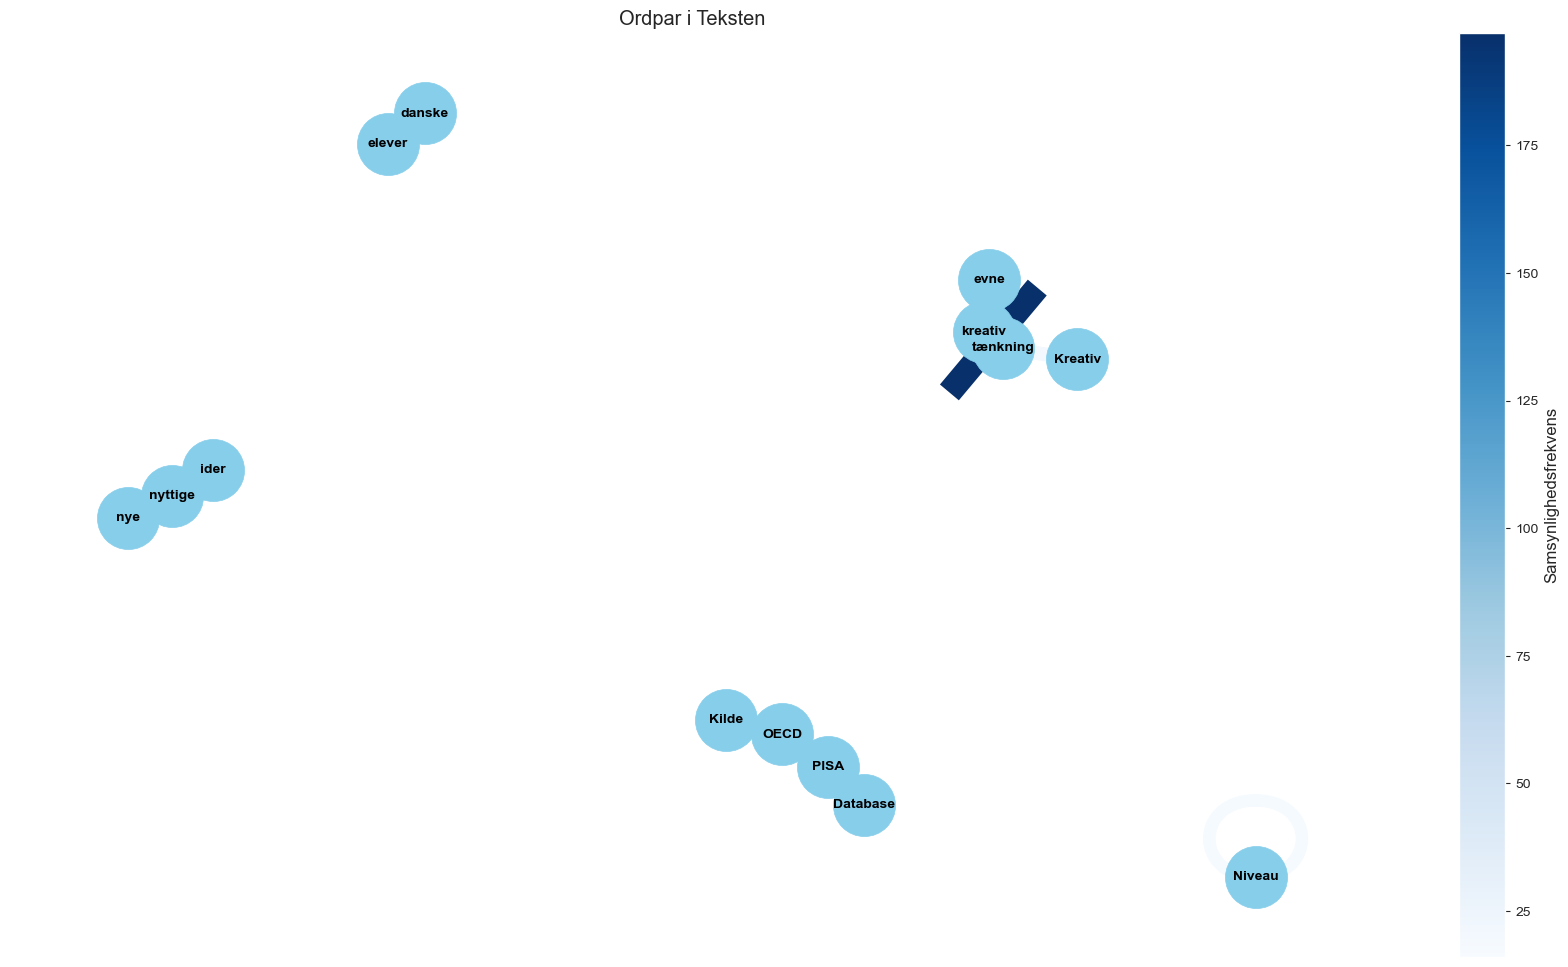

In [36]:
# Funktion til samsynlighedsanalyse med automatisk sprogdetektion og modelvalg
def co_occurrence_analysis(text, window_size=2):
    # Bestem sproget og få den passende spaCy-model
    language = detect_language(text)
    nlp = get_nlp_model(language)

    # Tokeniser og filtrer stopord
    doc = nlp(text)
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]

    # Find ordpar indenfor vinduet
    word_pairs = []
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i + window_size]
        word_pairs.extend(combinations(window, 2))

    # Tæl hyppigheden af hvert ordpar
    co_occurrences = Counter(word_pairs)
    return co_occurrences.most_common(10)  # Returner de 10 mest almindelige samsynlige ordpar

def plot_co_occurrence_network(co_occurrences):
    G = nx.Graph()

    # Tilføj noder og kanter baseret på samsynlige ordpar
    for (word1, word2), freq in co_occurrences:
        G.add_edge(word1, word2, weight=freq)

    # Brug spring_layout med en høj repulsion for at sprede noderne
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Øg k-værdien for mere spredning
    
    fig, ax = plt.subplots(figsize=(22, 12)) # Opret figur og akse. ORIGINAL ml 12 og 8
    edges = G.edges(data=True)
    edge_weights = [edge[2]['weight'] for edge in edges]  # Samsynlighedsfrekvenser som vægte

    # Tegn netværket med vægte som tykkelse af kanter
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000, ax=ax)  # Tegn på ax
    nx.draw_networkx_edges(G, pos, width=[w * 0.5 for w in edge_weights], edge_color=edge_weights, edge_cmap=plt.cm.Blues, ax=ax)  # Mindre vægt på kantbredde for bedre spredning
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)  # Tegn labels på ax

    plt.title("Ordpar i Teksten")
    plt.axis('off')

    # Tilføj farvebjælke baseret på kantvægt
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Samsynlighedsfrekvens')
    plt.show()

# Eksempel på eksekvering
if cleaned_text_global:
    co_occurrences = co_occurrence_analysis(cleaned_text_global)
    print("Mest almindelige ordpar:", co_occurrences)
    plot_co_occurrence_network(co_occurrences)
else:
    print("cleaned_text_global er tom eller ikke defineret.")


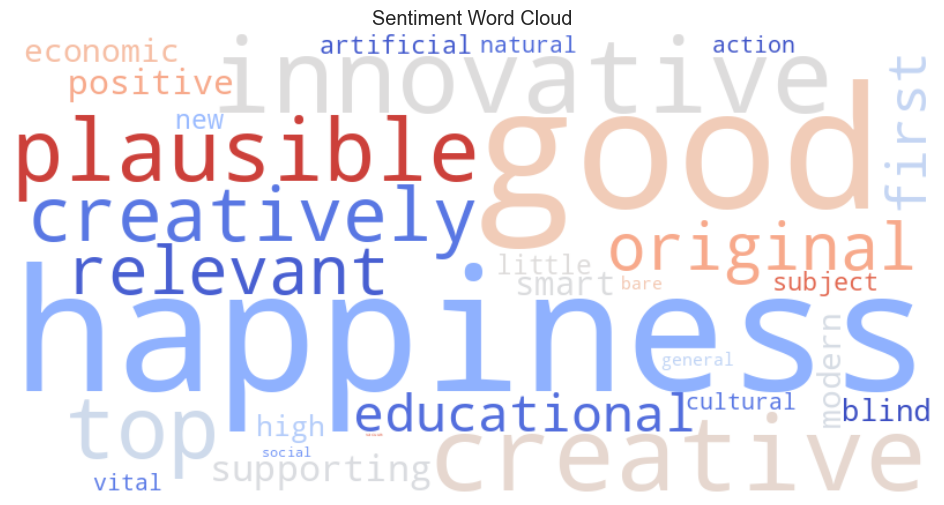

In [37]:
def generate_sentiment_wordcloud(text):
    """
    Opretter en sentiment-baseret ordsky med danske stopord filtreret fra.

    Parameters:
    text (str): Tekst til analyse og ordsky.
    """
    # Udvidet stopordsliste og brug af spaCy til tokenisering
    stop_words = set(nlp_da.Defaults.stop_words) | set(string.punctuation) | {
        "og", "at", "det", "mod", "som", "på", "er", "ubu", "pa", "and", "the",
        "breredygtighed", "breredygtig", "vrere", "af", "en", "i", "til", "med"
    }

    doc = nlp_da(text.lower())
    word_sentiments = {}

    # Skab en ordfrekvens- og sentiment-dictionary
    for token in doc:
        if token.text not in stop_words and token.is_alpha and len(token.text) > 2:
            word_blob = TextBlob(token.text)
            polarity = word_blob.sentiment.polarity
            if polarity != 0:  # Kun medtag ord med non-neutral polaritet
                word_sentiments[token.text] = polarity

    # Konfigurer WordCloud med sentiment som farvekode
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='coolwarm',  # Bruger coolwarm farvepalette til negativ/positiv
                          contour_color='black',
                          contour_width=1).generate_from_frequencies(word_sentiments)

    # Plot WordCloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title("Sentiment Word Cloud")
    plt.show()

# Kald funktionen på cleaned_text_global
if cleaned_text_global:
    generate_sentiment_wordcloud(cleaned_text_global)
else:
    print("cleaned_text_global er tom eller ikke defineret.")


In [38]:
def spacy_keyphrase_extraction(text, num_phrases=10):
    # Sprogdetektion og modelvalg
    language = detect_language(text)
    nlp = get_nlp_model(language)

    # Analyse af tekst og valg af målordsætninger
    doc = nlp(text)
    phrases = []

    for chunk in doc.noun_chunks:
        # Vælg substantivgrupper som målordsætninger
        if chunk.text.lower() not in nlp.Defaults.stop_words:
            phrases.append(chunk.text)

    # Tæl og sorter de mest almindelige sætninger
    phrase_counts = Counter(phrases)
    return phrase_counts.most_common(num_phrases)

# Eksempel på brug
if cleaned_text_global:
    key_phrases = spacy_keyphrase_extraction(cleaned_text_global)
    print("Top nøglefraser fundet med spaCy:")
    for phrase, count in key_phrases:
        print(f"{phrase} (Antal: {count})")
else:
    print("cleaned_text_global er tom eller ikke defineret.")


Top nøglefraser fundet med spaCy:
kreativ tænkning (Antal: 183)
PISA (Antal: 62)
OECD (Antal: 58)
Figur (Antal: 49)
eleverne (Antal: 46)
Danmark (Antal: 45)
ider (Antal: 42)
kreativitet (Antal: 41)
elevernes (Antal: 37)
niveau (Antal: 34)


In [39]:
def rake_keyphrase_extraction(text, num_phrases=10):
    # Initialiser RAKE og analyser teksten
    rake = Rake(language="danish")  # Juster til "danish" for danske tekster
    rake.extract_keywords_from_text(text)

    # Få de vigtigste nøglesætninger (efter vægtning)
    key_phrases = rake.get_ranked_phrases_with_scores()
    return key_phrases[:num_phrases]

# Eksempel på brug
if cleaned_text_global:
    key_phrases = rake_keyphrase_extraction(cleaned_text_global)
    print("Top nøglefraser fundet af RAKE:")
    for score, phrase in key_phrases:
        print(f"{phrase} (Score: {score})")
else:
    print("cleaned_text_global er tom eller ikke defineret.")

Top nøglefraser fundet af RAKE:
statistisk signifikant forskellig singapore korea canada australien canada korea australien australien korea canada new zealand estland finland estland new zealand finland danmark finland new zealand estland danmark letland danmark estland finland letland belgien letland finland danmark belgien polen belgien danmark letland polen polen letland belgien portugal portugal polen litauen spanien oecd tjekkiet taipei kina tyskland frankrig holland israel spanien litauen oecd tjekkiet taipei kina tyskland frankrig holland israel oecd litauen spanien oecd tjekkiet taipei kina tyskland frankrig holland israel tjekkiet litauen spanien oecd tjekkiet taipei kina tyskland frankrig holland israel taipei kina litauen spanien oecd tjekkiet tyskland frankrig holland israel tyskland litauen spanien oecd tjekkiet taipei kina frankrig holland israel hong kong kina frankrig litauen spanien oecd tjekkiet taipei kina tyskland holland israel hong kong kina holland litauen spani

In [40]:
# Funktion til at visualisere sentiment over tid med glidende gennemsnit og lineær regression
def sentiment_over_time(text):
    if not text or text.strip() == "":
        print("Teksten er tom og kan ikke analyseres.")
        return

    # Del teksten op i større sektioner (fx afsnit)
    paragraphs = [p.strip() for p in text.split('\n') if p.strip()]
    if len(paragraphs) < 3:
        print("Teksten har for få afsnit til at beregne glidende gennemsnit eller trend.")
        return

    polarities = []
    subjectivities = []
    indices = list(range(len(paragraphs)))

    # Beregn polarity og subjectivity for hver sektion
    for paragraph in paragraphs:
        blob = TextBlob(paragraph)
        polarities.append(blob.sentiment.polarity)
        subjectivities.append(blob.sentiment.subjectivity)

    # Glidende gennemsnit (3-afsnitsvindue) for polaritet og subjektivitet
    polarities_smooth = pd.Series(polarities).rolling(window=3, center=True).mean().dropna()
    subjectivities_smooth = pd.Series(subjectivities).rolling(window=3, center=True).mean().dropna()

    # Opdater indeks til smoothed data
    smoothed_indices = range(len(polarities_smooth))

    # Beregn lineær regression for polariteter og subjektiviteter
    slope_pol, intercept_pol, _, _, _ = linregress(indices, polarities)
    trend_pol = intercept_pol + slope_pol * np.array(indices)

    slope_subj, intercept_subj, _, _, _ = linregress(indices, subjectivities)
    trend_subj = intercept_subj + slope_subj * np.array(indices)

    # Visualiser sentiment med trendlinjer og glidende gennemsnit
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_indices, polarities_smooth, label="Polarity (Glidende Gennemsnit)", color='blue', linestyle='-')
    plt.plot(indices, trend_pol, label="Polarity Trend", color='blue', linestyle='--')
    plt.plot(smoothed_indices, subjectivities_smooth, label="Subjectivity (Glidende Gennemsnit)", color='orange', linestyle='-')
    plt.plot(indices, trend_subj, label="Subjectivity Trend", color='orange', linestyle='--')

    # Tilføj hældningstekst for trendlinjerne
    plt.text(len(indices)-1, trend_pol[-1], f'Slope: {slope_pol:.2f}', color='blue', fontsize=10, ha='left')
    plt.text(len(indices)-1, trend_subj[-1], f'Slope: {slope_subj:.2f}', color='orange', fontsize=10, ha='left')

    plt.xlabel("Afsnit nr.")
    plt.ylabel("Sentimentværdi")
    plt.title("Sentimentanalyse over tid med Trend og Glidende Gennemsnit")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Kontroller indholdet af cleaned_text_global
if 'cleaned_text_global' in globals() and cleaned_text_global:
    print("cleaned_text_global er tilgængelig og indeholder tekst.")
    print(cleaned_text_global[:500])  # Udskriv de første 500 tegn for at bekræfte
    sentiment_over_time(cleaned_text_global)
else:
    print("cleaned_text_global er ikke defineret eller indeholder ingen tekst.")

cleaned_text_global er tilgængelig og indeholder tekst.
 PISA Kreativ tænkning Kompetencen til at kunne få og forme forskellige nye nyttige ider Delrapport Henrik Wøhlk Larsen og Raffaele BraheOrlandi PISA Kreativ tænkning Kompetencen til at kunne få og forme forskellige nye nyttige ider. Delrapport. VIVE og forfatterne eISBN Forsidegrafik Hanne Bang ChristensenVIVE Projekt Finansiering Børne og Undervisningsministeriet VIVE Det Nationale Forsknings og Analysecenter for Velfærd Herluf Trolles Gade København K VIVEs publikationer kan frit citeres med 
Teksten har for få afsnit til at beregne glidende gennemsnit eller trend.


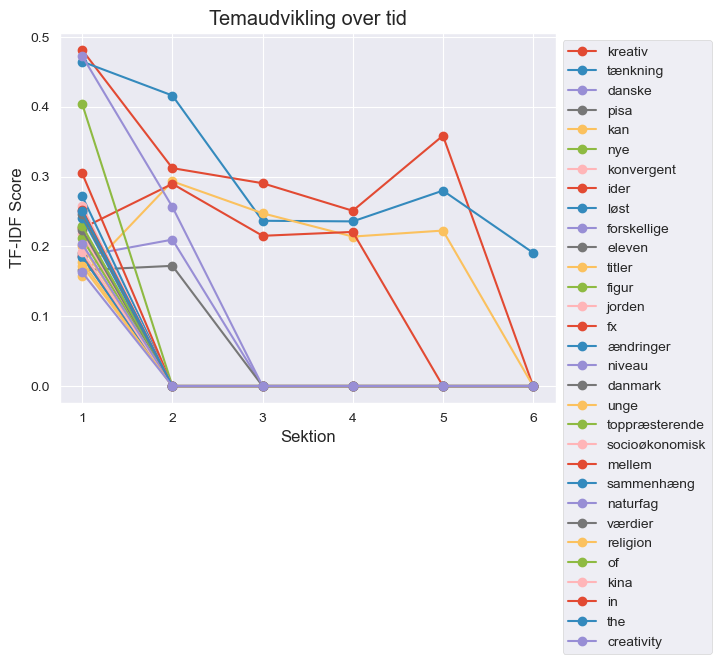

In [41]:
# Funktion til at vælge den relevante stopordsliste baseret på sprog
def get_stopwords(language):
    if language == "da":
        return danish_stopwords
    elif language == "en":
        return english_stopwords
    else:
        return []

# Funktion til at opdele tekst i sektioner
def split_text_into_sections(text, num_sections=10):
    words = text.split()
    section_length = len(words) // num_sections
    sections = [' '.join(words[i * section_length:(i + 1) * section_length]) for i in range(num_sections)]
    return sections

# Funktion til at identificere temaer med TF-IDF i hver sektion
def theme_identification_by_section(sections, language, num_themes=5):
    stop_words = get_stopwords(language)  # Vælg stopordsliste baseret på sprog
    vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)
    tfidf_matrix = vectorizer.fit_transform(sections)
    feature_names = vectorizer.get_feature_names_out()

    # Find top-temaer per sektion baseret på TF-IDF score
    theme_data = []
    for idx, section in enumerate(sections):
        scores = tfidf_matrix[idx].toarray().flatten()
        top_indices = scores.argsort()[-num_themes:][::-1]
        top_words = [(feature_names[i], scores[i]) for i in top_indices]
        theme_data.append((f"Sektion {idx+1}", top_words))

    return theme_data

# Funktion til at visualisere temaudvikling over tid
def plot_theme_evolution(theme_data):
    theme_dict = {}

    # Organiser temaerne til visualisering
    for section, themes in theme_data:
        for word, score in themes:
            if word not in theme_dict:
                theme_dict[word] = []
            theme_dict[word].append(score)

    # Fyld med 0'er for sektioner uden ord
    max_length = max(len(scores) for scores in theme_dict.values())
    for scores in theme_dict.values():
        scores.extend([0] * (max_length - len(scores)))

    # Visualiser hvert tema
    for theme, scores in theme_dict.items():
        plt.plot(range(1, max_length + 1), scores, label=theme, marker='o')

    plt.xlabel("Sektion")
    plt.ylabel("TF-IDF Score")
    plt.title("Temaudvikling over tid")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.xticks(range(1, max_length + 1))
    plt.show()

# Eksempel på eksekvering
if cleaned_text_global:
    # Bestem tekstens sprog
    language = detect_language(cleaned_text_global)

    # Del teksten op i sektioner
    sections = split_text_into_sections(cleaned_text_global, num_sections=10)

    # Identificer temaer for hver sektion baseret på sproget
    theme_data = theme_identification_by_section(sections, language)

    # Visualiser temaudviklingen
    plot_theme_evolution(theme_data)
else:
    print("cleaned_text_global er tom eller ikke defineret.")